# Лабораторная работа №5 по курсу "Нейроинформатика".
Выполнил Пищик Е.С. М8О-406Б-19.

## Цель работы.

Исследование свойств сетей Хопфилда, Хэмминга и Элмана, алгоритмов обучения, а также применение сетей в задачах распознавания статических и динамических образов.

## Часть 1.

In [83]:
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
from torch.nn import MSELoss
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch
from PIL import Image
import matplotlib.animation as animation

In [84]:
import warnings
warnings.filterwarnings('ignore')

In [85]:
def make_signal(r1=3, r2=1, r3=3):
    k1, k2 = np.arange(0, 1, 0.025), np.arange(0.01, 2.77, 0.025)
    p1, p2 = np.sin(4 * np.pi * k1), np.sin(-np.sin(k2) * k2**2 + k2)
    t1, t2 = -1 * np.ones(len(p1)), np.ones(len(p2))

    assert len(k1) == len(p1) and len(k1) == len(t1)
    assert len(k2) == len(p2) and len(k2) == len(t2)

    tile11 = np.tile(p1, r1)
    tile12 = np.tile(p1, r2)
    tile13 = np.tile(p1, r3)

    signal = np.concatenate((tile11, p2, tile12, p2, tile13, p2))

    tile21 = np.tile(t1, r1)
    tile22 = np.tile(t1, r2)
    tile23 = np.tile(t1, r3)

    labels = np.concatenate((tile21, t2, tile22, t2, tile23, t2))

    return signal, labels

In [86]:
def get_loader(signal, labels, window=1):
    signal_range = range(0, len(signal) - window)
    signal_seq = [np.array(signal[i:i + window], dtype=np.float32)
                  for i in signal_range]

    labels_range = range(0, len(labels) - window)
    labels_seq = [np.array(labels[i:i + window], dtype=np.float32)
                  for i in labels_range]

    output = [(x, y) for x, y in zip(signal_seq, labels_seq)]
    loader = DataLoader(output, batch_size=1, shuffle=False)

    return output, loader

In [87]:
class Elman(nn.Module):
    def __init__(self, inp, h, out, numl, act):
        super().__init__()
        self.rnn = nn.RNN(input_size=inp,
                          hidden_size=h,
                          num_layers=numl,
                          nonlinearity=act,
                          batch_first=True)
        self.fc = nn.Linear(h, out)

    def forward(self, x):
        _, hn = self.rnn(x)
        fc = self.fc(hn[-1]).unsqueeze(0)
        return fc

In [88]:
epochs = 100
r1, r2, r3 = 3, 1, 3
window = 10
hidden = 16
num_layers = 2
activation = 'tanh'
lr = 1e-2

In [89]:
signal, labels = make_signal(r1, r2, r3)

train_dataset, train_loader = get_loader(signal, labels, window=window)

In [90]:
model = Elman(window, hidden, window, num_layers, activation)
optimizer = Adam(model.parameters(), lr=lr)
criterion = MSELoss()

In [91]:
model.train()

tqdm_iter = tqdm(range(epochs))
for epoch in tqdm_iter:
    train_loss = 0.0

    for batch in train_loader:
        sig, lab = batch[0], batch[1]

        out = model(sig)

        loss = criterion(out, lab)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    tqdm_iter.set_postfix(
        {'epoch:': f'{epoch + 1}/{epochs}', 'train loss:': train_loss})

    tqdm_iter.refresh()

100%|██████████| 100/100 [01:23<00:00,  1.19it/s, epoch:=100/100, train loss:=0.169]


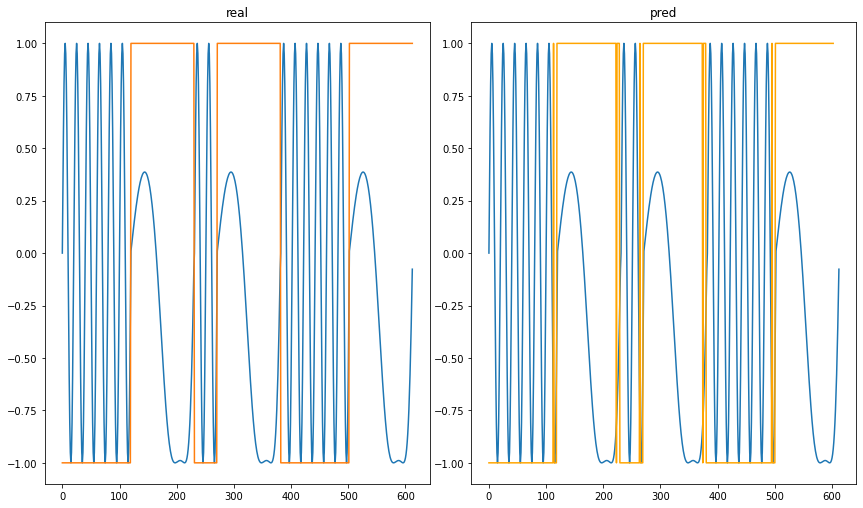

In [92]:
model.eval()

predict = []
for x, y in train_dataset:
    tens = torch.tensor(x).unsqueeze(0)
    val = model(tens).detach().numpy().item(0)
    predict += [val]

predict = np.array(predict)
predict[predict > 0] = 1
predict[predict < 0] = -1

fig, axes = plt.subplots(1, 2, figsize=(12, 7))
fig.tight_layout()

axes[0].set_title('real')
axes[0].plot(signal)
axes[0].plot(labels)

axes[1].set_title('pred')
axes[1].plot(signal)
axes[1].plot(predict, color='orange')

plt.show()

## Часть 2.

In [93]:
class Hopfield(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.w = nn.Parameter(torch.zeros(in_features, in_features))
        self.b = nn.Parameter(torch.zeros(in_features))
        self.prev = torch.tensor(torch.zeros(in_features, in_features))
    
    def set_init(self, val):
        self.prev = torch.tensor(val)
    
    def forward(self, input=0):
        out = torch.matmul(self.prev, self.w)
        out = torch.add(out, self.b)
        out = torch.clamp(out, min=-1, max=1)
        self.prev = torch.tensor(out)
        return out

In [94]:
def load_image(path, w, h):
    img = Image.open(path)
    img = img.convert('RGB')
    img = img.resize((w, h), Image.ANTIALIAS)
    img = np.asarray(img, dtype=np.float32)
    img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.float32)
    img = (img - 127.5) / 127/5
    return img.flatten()

In [95]:
def load_data(w, h):
    out = [(load_image('./1.png', w, h), load_image('./1.png', w, h))]
    out += [(load_image('./2.png', w, h), load_image('./2.png', w, h))]
    out += [(load_image('./3.png', w, h), load_image('./3.png', w, h))]
    return out

In [96]:
def update_fig(*args):
    global im_axes
    im_axes.set_array(frames[update_fig.counter])
    update_fig.counter = (update_fig.counter + 1) % len(frames)
    return im_axes

In [97]:
frames = []
im_axes = 0
update_fig.counter = 0
epochs = 300
w, h = 10, 12
lr = 1e-3

In [98]:
model = Hopfield(w * h)
optimizer = Adam(model.parameters(), lr=lr)
criterion = MSELoss()

In [99]:
train_dataset = load_data(w, h)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [100]:
model.train()

tqdm_iter = tqdm(range(epochs))
for epoch in tqdm_iter:
    train_loss = 0.0

    for batch in train_loader:
        inp, out = batch[0], batch[1]

        pred = model()

        loss = criterion(pred, out)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    tqdm_iter.set_postfix(
        {'epoch:': f'{epoch + 1}/{epochs}', 'train loss:': train_loss})

    tqdm_iter.refresh()

100%|██████████| 300/300 [00:03<00:00, 88.93it/s, epoch:=300/300, train loss:=0.0109]


In [101]:
model.eval()

Hopfield()

In [102]:
target = train_dataset[2][0]
init = np.copy(target)
init += np.random.normal(0, 0.15, init.shape)
init = (init + 1) / 2

In [103]:
model.set_init(init)

In [104]:
for i in range(10):
    out = model().detach().numpy()
    out = (out + 1) / 2
    out = np.reshape(out, (h, w))
    frames += [out]

In [105]:
target = np.reshape(out, (h, w))
init = np.reshape(init, (h, w))

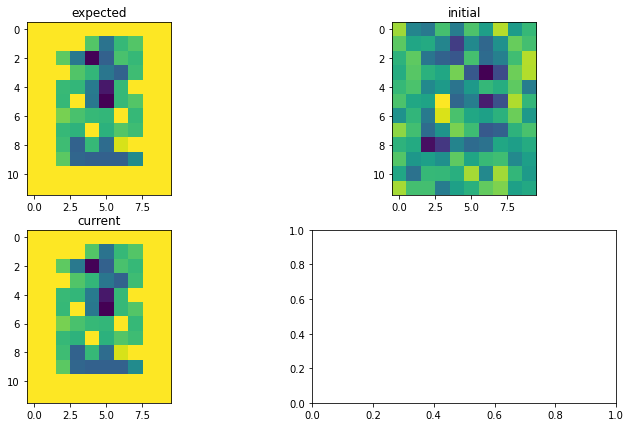

In [108]:
fig, axes = plt.subplots(2, 2, figsize=(12,7))

axes[0, 0].set_title('expected')
axes[0, 0].set_aspect(1)
axes[0, 0].imshow(target)

axes[0, 1].set_title('initial')
axes[0, 1].set_aspect(1)
axes[0, 1].imshow(init)

axes[1, 0].set_title('current')
axes[1, 0].set_aspect(1)
axes[1, 0].imshow(frames[-1])

plt.show()

## Выводы.

В данной лабораторной работе мы научились работать с моделями Элмана и Хопфилда для обработки последовательностей.